# BiT - Big image Transfer - Example

Example of Using Google's Big Image Transfer Technique on the CIFAR-100 Dataset

### Imports

In [162]:
from functools import partial
import time
import os

import numpy as np
import input_pipeline_tf2_or_jax as input_pipeline
import bit_tf2.models as models
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import pickle

tf.enable_v2_behavior()

import bit_common
import bit_hyperrule

from PIL import Image

import requests
from io import BytesIO
import matplotlib.pyplot as plt


### Load And Train Model via command Line


```sh
python3 -m bit_{pytorch|jax|tf2}.train --name cifar10_`date +%F_%H%M%S` --model BiT-M-R50x1 --logdir /tmp/bit_logs --dataset cifar10
```



### Set configs

In [21]:
logdir = 'tmp/'
bit_pretrained_dir = '.'
dataset = 'cifar100'
name = 'test'
model = 'BiT-M-R50x1'
bit_model_file = 'BiT-M-R50x1.h5'
batch_eval = 32
batch = 128
batch_split = 1
tfds_manual_dir = None
examples_per_class = None
examples_per_class_seed = 0
base_lr= 0.001
eval_every = None


### Set Logger

In [22]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
d = AttrDict()
d.logdir = logdir
d.name = name

logger = bit_common.setup_logger(d)
logger.info(f'Available devices: {tf.config.list_physical_devices()}')

strategy = tf.distribute.MirroredStrategy()
num_devices = strategy.num_replicas_in_sync
print('Number of devices: {}'.format(num_devices))

2020-05-24 15:54:20,837 [INFO] bit_common: {'logdir': 'tmp/', 'name': 'test'}
2020-05-24 15:54:20,838 [INFO] bit_common: Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]


2020-05-24 15:54:20,839 [WARNING] tensorflow: There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2020-05-24 15:54:20,840 [INFO] tensorflow: Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


### Get dataset

In [85]:
dataset_info = input_pipeline.get_dataset_info(
    dataset, 'train', examples_per_class)
dataset_info

2020-05-26 10:52:50,232 [INFO] absl: Load dataset info from /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2


{'original_num_examples': 50000, 'num_examples': 50000, 'num_classes': 100}

In [110]:
def get_class_labels(dataset, split, examples_per_class):
    data_builder = tfds.builder(dataset)
    original_num_examples = data_builder.info.splits[split].num_examples
    classes = data_builder.info.features['label'].names
    return classes
    

dataset_classes = get_class_labels(dataset, 'train', examples_per_class)

2020-05-26 11:05:23,526 [INFO] absl: Load dataset info from /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2


### Save The Classes For Later

In [170]:
def save_classes(classes, filename):
    
    logger.info(f'Saving Classes to File {filename}')
    pickle.dump(classes, open(filename, 'wb'))
    
    
save_classes(dataset_classes, 'cifar_classes.pkl')

2020-05-26 11:31:09,939 [INFO] bit_common: Saving Classes to File cifar_classes.pkl


In [24]:
resize_size, crop_size = bit_hyperrule.get_resolution_from_dataset(dataset)


In [25]:
data_train = input_pipeline.get_data(
    dataset=dataset, mode='train',
    repeats=None, batch_size=batch,
    resize_size=resize_size, crop_size=crop_size,
    examples_per_class=examples_per_class,
    examples_per_class_seed=examples_per_class_seed,
    mixup_alpha=bit_hyperrule.get_mixup(dataset_info['num_examples']),
    num_devices=num_devices,
    tfds_manual_dir=tfds_manual_dir)

2020-05-24 15:55:16,281 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar100/3.0.2
2020-05-24 15:55:16,449 [INFO] absl: Load dataset info from /var/folders/gd/3nb3fp150sv5clsry0gx9v6c0000gn/T/tmp7l1ry_z4tfds
2020-05-24 15:55:16,452 [INFO] absl: Field info.citation from disk and from code do not match. Keeping the one from code.
2020-05-24 15:55:16,454 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar100/3.0.2
2020-05-24 15:55:16,620 [INFO] absl: Load dataset info from /var/folders/gd/3nb3fp150sv5clsry0gx9v6c0000gn/T/tmp0n7pk16etfds
2020-05-24 15:55:16,623 [INFO] absl: Field info.citation from disk and from code do not match. Keeping the one from code.
2020-05-24 15:55:16,624 [INFO] absl: Generating dataset cifar100 (/Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2)


2020-05-24 15:55:17,211 [INFO] absl: Downloading https://www.cs.toronto.edu/~kriz/cifar-100-binary.tar.gz into /Users/ramine.tinati/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-100-binaryzK0jb7CkNxmV4pH2clu5WdAlIotsPlZhrMxx9-DELEk.tar.gz.tmp.fc40ccc548c840ada59e5441e409064f...
/Users/ramine.tinati/anaconda3/envs/gpu-tf/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.cs.toronto.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
2020-05-24 15:56:07,839 [INFO] absl: Generating split train


Shuffling and writing examples to /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2.incompleteAGYOCL/cifar100-train.tfrecord


2020-05-24 15:56:35,765 [INFO] absl: Done writing /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2.incompleteAGYOCL/cifar100-train.tfrecord. Shard lengths: [50000]
2020-05-24 15:56:35,774 [INFO] absl: Generating split test


Shuffling and writing examples to /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2.incompleteAGYOCL/cifar100-test.tfrecord


2020-05-24 15:56:41,568 [INFO] absl: Done writing /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2.incompleteAGYOCL/cifar100-test.tfrecord. Shard lengths: [10000]
2020-05-24 15:56:41,572 [INFO] absl: Skipping computing stats for mode ComputeStatsMode.AUTO.
2020-05-24 15:56:41,575 [INFO] absl: Constructing tf.data.Dataset for split train[:98%], from /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2


Dataset cifar100 downloaded and prepared to /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [26]:
data_test = input_pipeline.get_data(
    dataset=dataset, mode='test',
    repeats=1, batch_size=batch,
    resize_size=resize_size, crop_size=crop_size,
    examples_per_class=1, examples_per_class_seed=0,
    mixup_alpha=None,
    num_devices=num_devices,
    tfds_manual_dir=tfds_manual_dir)

2020-05-24 15:56:41,689 [INFO] absl: Load dataset info from /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2
2020-05-24 15:56:41,692 [INFO] absl: Load dataset info from /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2
2020-05-24 15:56:41,695 [INFO] absl: Reusing dataset cifar100 (/Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2)
2020-05-24 15:56:41,696 [INFO] absl: Constructing tf.data.Dataset for split test, from /Users/ramine.tinati/tensorflow_datasets/cifar100/3.0.2


In [27]:
def reshape_for_keras(features, batch_size, crop_size):
    features["image"] = tf.reshape(features["image"], (batch_size, crop_size, crop_size, 3))
    features["label"] = tf.reshape(features["label"], (batch_size, -1))
    return (features["image"], features["label"])


In [28]:
data_train = data_train.map(lambda x: reshape_for_keras(
    x, batch_size=batch, crop_size=crop_size))
data_test = data_test.map(lambda x: reshape_for_keras(x, batch_size=batch, crop_size=crop_size))

### Set Up Model

In [29]:
with strategy.scope():
    filters_factor = int(model[-1])*4
    tf_model = models.ResnetV2(
        num_units=models.NUM_UNITS[model],
        num_outputs=21843,
        filters_factor=filters_factor,
        name="resnet",
        trainable=True,
        dtype=tf.float32)

    tf_model.build((None, None, None, 3))
    logger.info(f'Loading weights...')
    tf_model.load_weights(bit_model_file)
    logger.info(f'Weights loaded into model!')

    tf_model._head = tf.keras.layers.Dense(
        units=dataset_info['num_classes'],
        use_bias=True,
        kernel_initializer="zeros",
        trainable=True,
        name="head/dense")

    lr_supports = bit_hyperrule.get_schedule(dataset_info['num_examples'])

    schedule_length = lr_supports[-1]
    # NOTE: Let's not do that unless verified necessary and we do the same
    # across all three codebases.
    # schedule_length = schedule_length * 512 / args.batch

    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    tf_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])


2020-05-24 15:56:43,913 [INFO] bit_common: Loading weights...
2020-05-24 15:56:44,239 [INFO] bit_common: Weights loaded into model!


### Train Model

In [30]:
# tf_model.summary()

In [31]:
class BiTLRSched(tf.keras.callbacks.Callback):
    
    def __init__(self, base_lr, num_samples):
        self.step = 0
        self.base_lr = base_lr
        self.num_samples = num_samples

    def on_train_batch_begin(self, batch, logs=None):
        lr = bit_hyperrule.get_lr(self.step, self.num_samples, self.base_lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.step += 1


In [32]:
logger.info(f'Fine-tuning the model...')
tf.io.gfile.makedirs(logdir)
tf.io.gfile.makedirs(bit_pretrained_dir)

steps_per_epoch = eval_every or schedule_length

history = tf_model.fit(
  data_train,
  steps_per_epoch=steps_per_epoch,
  epochs=schedule_length // steps_per_epoch,
  validation_data=data_test,  # here we are only using
                              # this data to evaluate our performance
  callbacks=[BiTLRSched(base_lr, dataset_info['num_examples'])],
)

2020-05-24 15:56:44,296 [INFO] bit_common: Fine-tuning the model...


10000/10000 [==============================] - 121829s 12s/step - loss: 0.6791 - accuracy: 0.9091 - val_loss: 0.4889 - val_accuracy: 0.8649


### Evaluate

In [35]:
for epoch, accu in enumerate(history.history['val_accuracy']):
    logger.info(
            f'Step: {epoch }, '
            f'Test accuracy: {accu:0.3f}')

2020-05-26 10:01:19,031 [INFO] bit_common: Step: 0, Test accuracy: 0.865


### Export Model (Generic TF Export)|

In [39]:
model_name = '{}_finetined'.format(model)
model_dir = 'models'
model_path = '{}/{}'.format(model_dir, model_name)

#create DIR
tf.io.gfile.makedirs(model_dir)
#Save 
logger.info(f'Saving the model...')

tf_model.save(model_path, save_format='tf')

2020-05-26 10:02:57,303 [INFO] bit_common: Saving the model...


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-05-26 10:03:32,735 [WARNING] tensorflow: From /Users/ramine.tinati/anaconda3/envs/gpu-tf/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: models/BiT-M-R50x1_finetined/assets


2020-05-26 10:03:40,159 [INFO] tensorflow: Assets written to: models/BiT-M-R50x1_finetined/assets


### Alternative Export

In [42]:
# Save fine-tuned model as SavedModel
export_module_dir = 'models/saved_bit_model/'
tf.saved_model.save(tf_model, export_module_dir)

INFO:tensorflow:Assets written to: models/saved_bit_model/assets


2020-05-26 10:13:28,204 [INFO] tensorflow: Assets written to: models/saved_bit_model/assets


### Load The Model and Classes

If You're starting from a cold kernel, you can run straight from here!

In [171]:
def load_classes(filename):
    
    logger.info(f'Loading Classes from File {filename}')
    
    classes = pickle.load(open(filename, 'rb'))
    return classes   

def load_model(model_path):
    logger.info(f'Loading Model from File {model_path}')
    model = hub.KerasLayer(model_path, trainable=True)
    return model
    
classes_tmp = load_classes('cifar_classes.pkl')
model_tmp = load_model(export_module_dir)


2020-05-26 11:31:28,698 [INFO] bit_common: Loading Classes from File cifar_classes.pkl
2020-05-26 11:31:28,700 [INFO] bit_common: Loading Model from File models/saved_bit_model/


## Prediction

In [126]:
# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 10
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 


In [149]:
def preprocess_image(image):
    image = np.array(image)
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
    return image

def load_image_from_url(url):
    """Returns an image with shape [1, height, width, num_channels]."""
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image = preprocess_image(image)
    return image

def load_image_from_file(path):
    """Returns an image with shape [1, height, width, num_channels]."""
    image_raw = Image.open(path)
    image = preprocess_image(image_raw)
    return image_raw, image


In [172]:
def predict(model, image_file, resize = False):

    img_raw, img_processed = load_image_from_file(image_file)
    
    if resize:
        img_processed = tf.image.resize(img_processed, [resize[0], resize[1]])

    logits = tf_model.predict(img_processed)
   
    return logits

In [156]:
def show_preds(logits, image, dataset_classes):

    fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)
    
    ax1, ax2 = axes[0]

    ax1.axis('off')
    ax1.imshow(image)
   

    logits_max = np.max(logits)
    softmax_denominator = np.sum(np.exp(logits - logits_max))
    
    if len(logits.shape) > 1:
        logits = tf.reshape(logits, [-1])

    classes = []
    scores = []
    for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
        score = 1.0/(1.0 + np.exp(-logits[j]))
        if score < MIN_SCORE: break
            
        print(score, dataset_classes[j])
        classes.append(dataset_classes[j])
        scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

    ax2.barh(np.arange(len(scores)) + 0.1, scores)
    ax2.set_xlim(0, 100)
    ax2.set_yticks(np.arange(len(scores)))
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticklabels(classes, rotation=0, fontsize=14)
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_xlabel('Prediction probabilities', fontsize=11)


0.999868840958737 castle
0.9256489003805611 skyscraper
0.8935802297400238 telephone
0.880330160750405 rocket
0.8095261428293672 tank
0.808645215576402 snake


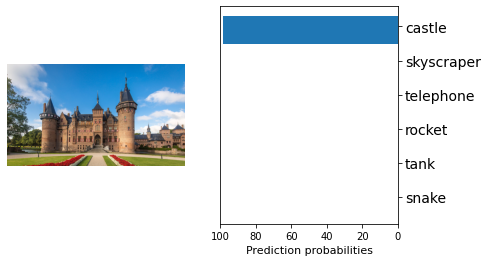

In [176]:
image_fl = 'data/cartoon_bean.jpg'
preds_logits = predict(model_tmp, image_fl, resize = (resize_size, crop_size))
show_preds(preds_logits, img_raw, classes_tmp)